# SC Analysis pipeline

Here we try to run a SOTA SC analysis pipeline for cell type annotation including
- QC
- UMAP
- Clustering
- Cell type Annotation using predefined markers
- Cell type annotation using DEG

adapted from https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

use cell markers from http://xteam.xbio.top/CellMarker/search.jsp?species=Human&tissue=Lung&cellname=Epithelial%20cell

This is for the ENACT outputs of the Lung cancer sample

In [ ]:
import pandas as pd
import scanpy as sc

In [ ]:
output_path_cells = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-05-14--11-40-13/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2"
# Anndata object path
cells_adata_path = f"{output_path_cells}/tmap/weighted_by_area|celltypist_cells_adata.h5"

# Loading Anndata object
adata = sc.read_h5ad(cells_adata_path)

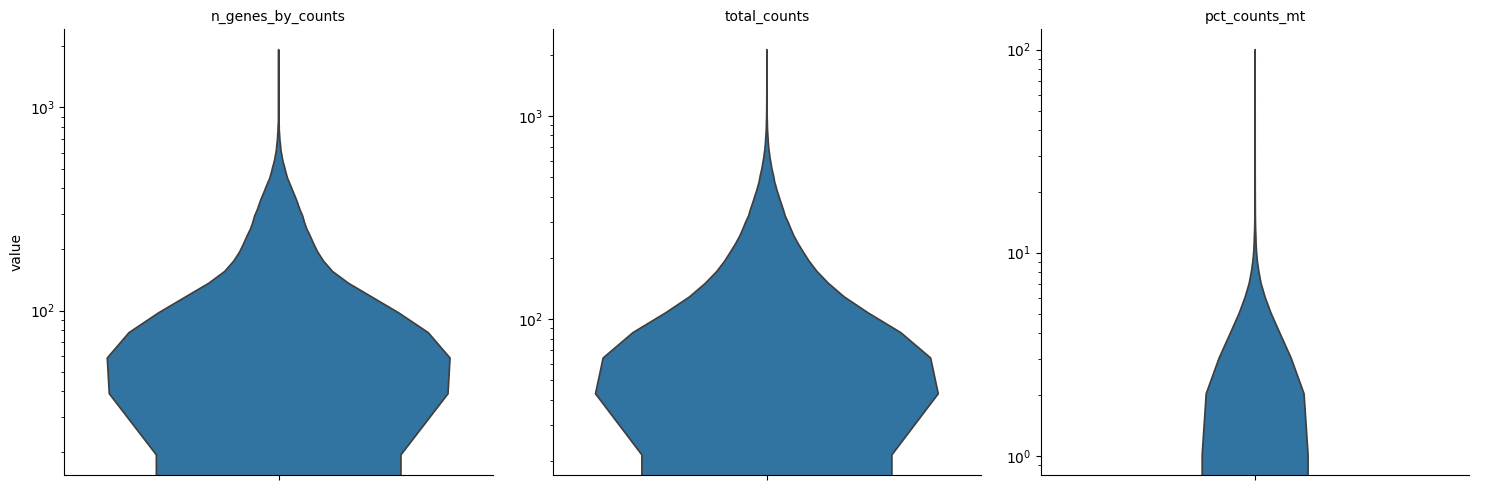

In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Violin plot with log scale for y-axis
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot=False,
    multi_panel=True,
    log=True,
    save="_qc_violin.png"
)


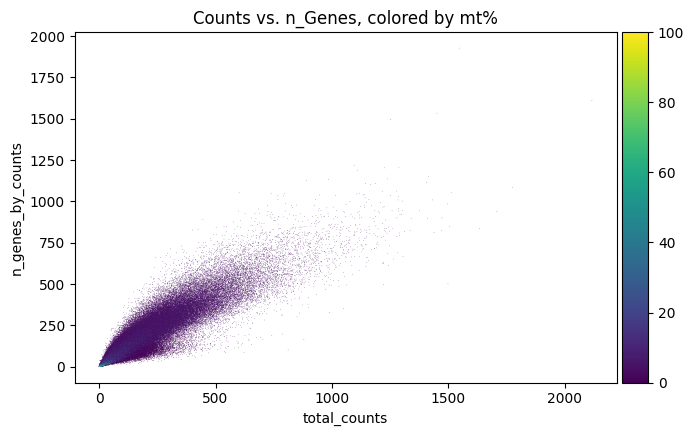

In [ ]:
# Report mean and median for each metric
for col in ["n_genes_by_counts", "total_counts", "pct_counts_mt"]:
    mean_val = adata.obs[col].mean()
    median_val = adata.obs[col].median()

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="Counts vs. n_Genes, colored by mt%", save="_qc_scatter.png")

sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)

# skipping doublet detection as we expect no doublets in ST

adata.layers["counts"] = adata.X.copy()


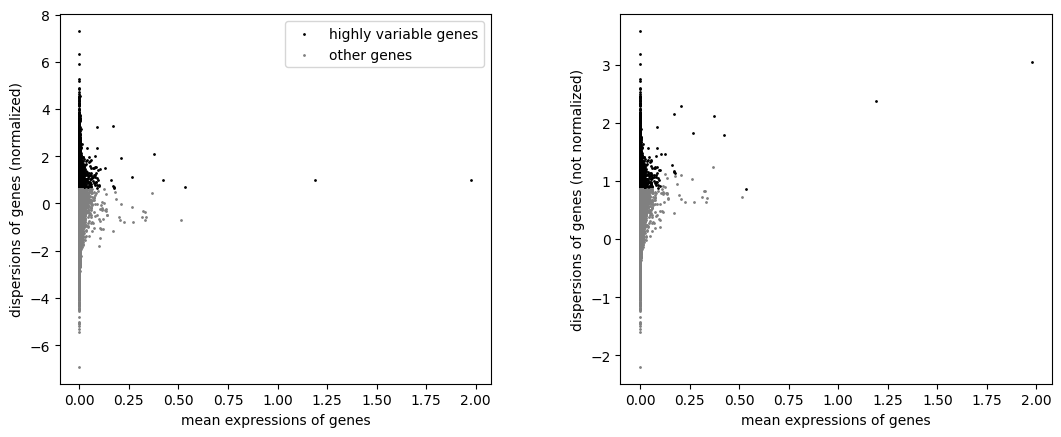

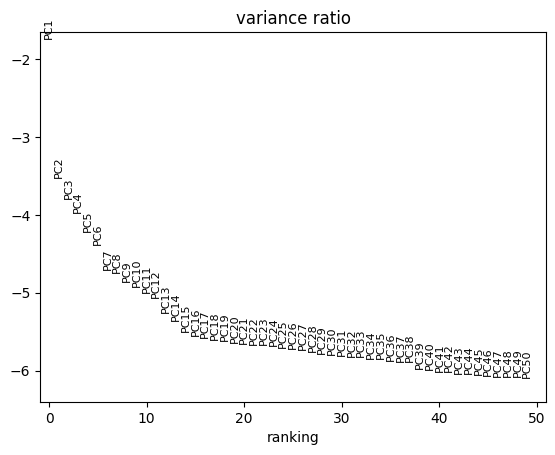

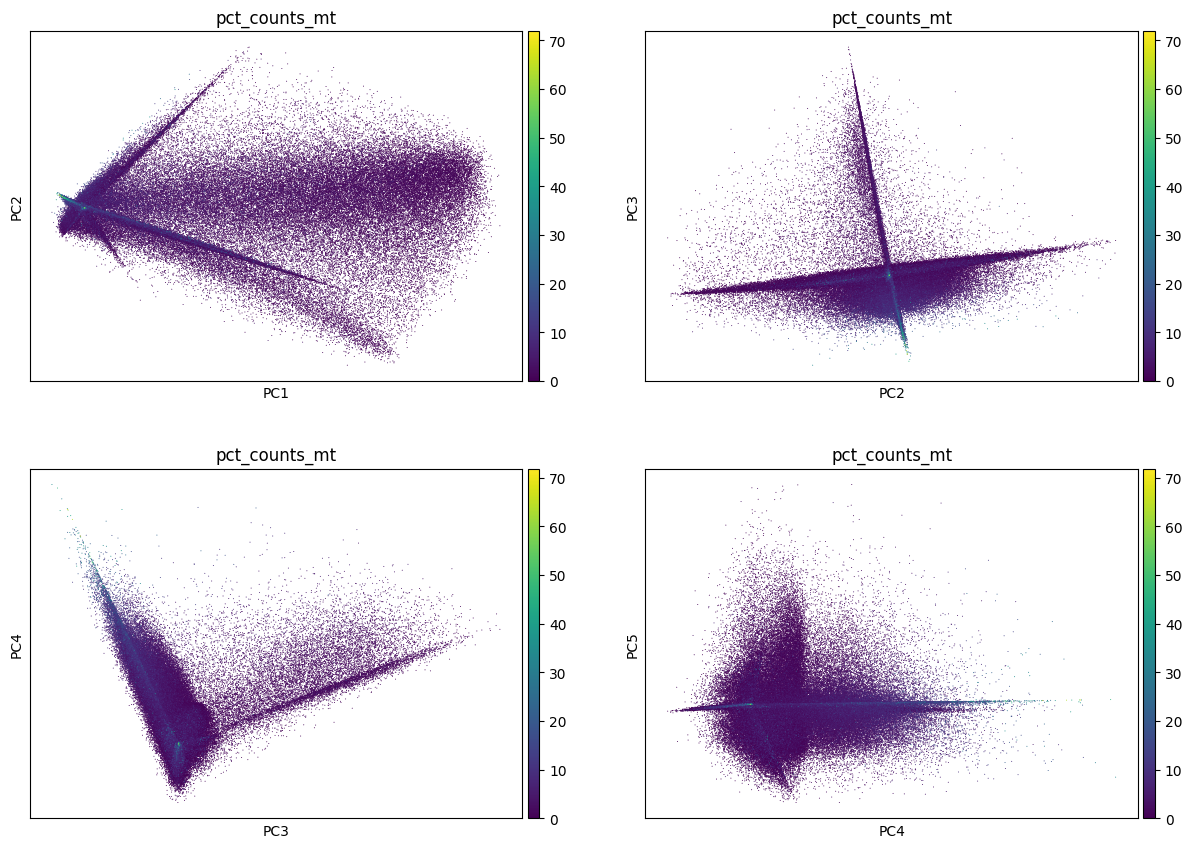

In [5]:

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000)

sc.pl.highly_variable_genes(adata, save="_qc_hvg.png")

sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save="_qc_pca_variance_ratio.png")

sc.pl.pca(
    adata,
    color=["pct_counts_mt", "pct_counts_mt", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (1, 2), (2, 3), (3, 4)],
    ncols=2,
    size=2,
    save="_qc_pca.png"
)

In [6]:
sc.pp.neighbors(adata)


/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-19 15:04:27.703835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 15:04:28.081473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 15:04:28.190098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-19 15:04:28.931253: I tensorflow/core/platform/cpu_feature_guard.cc:210] T

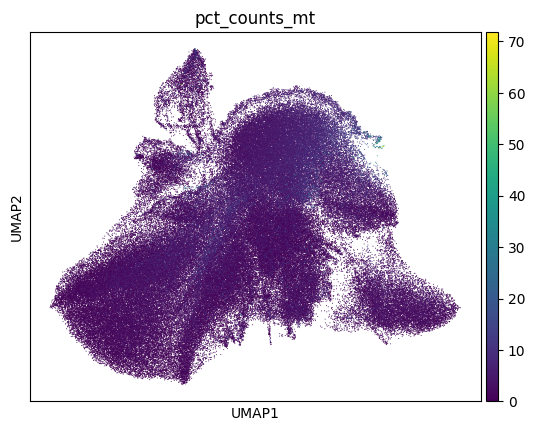

In [7]:
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="pct_counts_mt",
    # Setting a smaller point size to get prevent overlap
    size=2,
    save="_qc_umap.png"
)

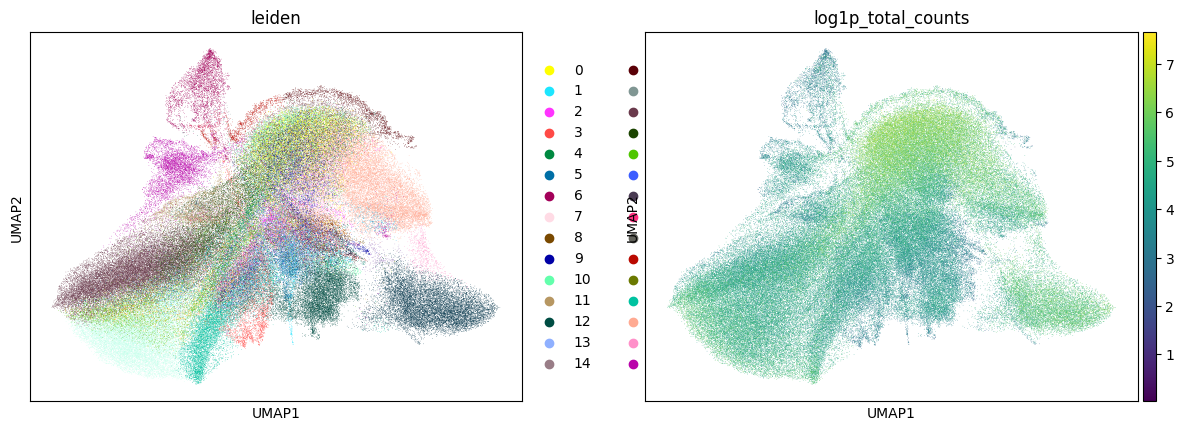

In [8]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

sc.pl.umap(adata, color=["leiden", "log1p_total_counts"], save="_qc_umap_leiden.png")


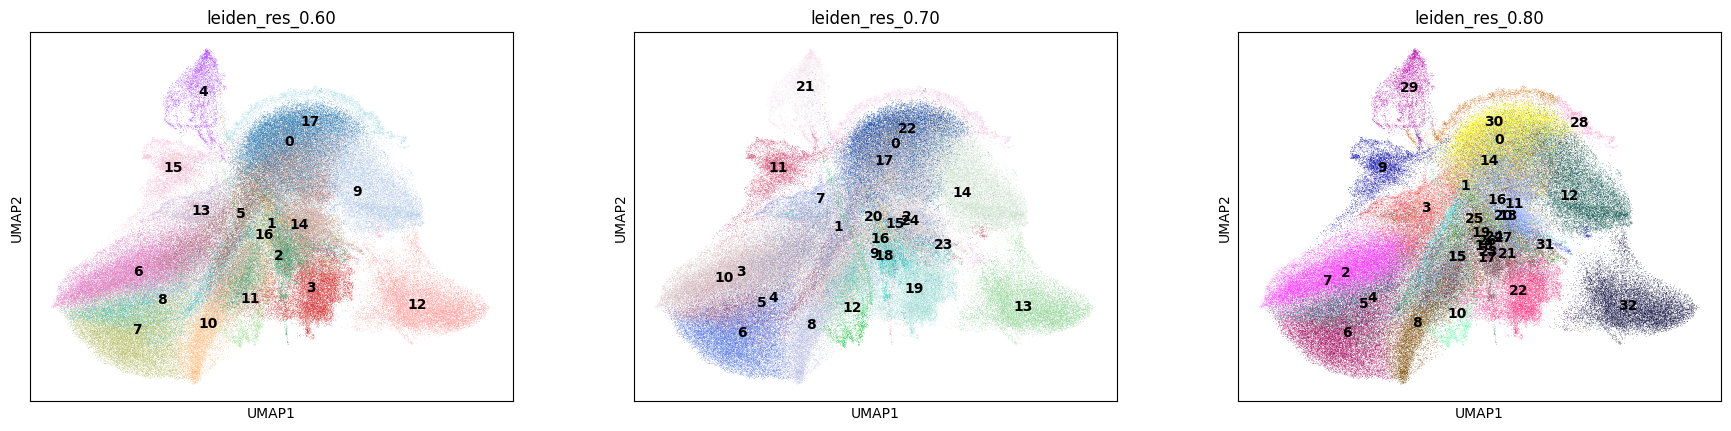

In [9]:
for res in [0.6,0.7, 0.8]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

sc.pl.umap(
    adata,
    color=["leiden_res_0.60", "leiden_res_0.70", "leiden_res_0.80"],
    legend_loc="on data",
    save="_qc_umap_leiden_resolutions.png"
)

In [10]:
marker_genes = {
    "Adenocarcinoma": ["MUC1", "CEACAM6", "NAPSA", "PHLDA2", "EPCAM"],
    "Plasma cell": ["MZB1", "SDC1", "PRDM1", "XBP1", "IGJ"],
    "Naive CD4 T cell": ["CCR7", "LEF1", "SELL", "TCF7", "IL7R"],
    "abT (entry) cell": ["TRAC", "TRBC1", "CD3D", "CD3E", "CD3G"],
    "T cell": ["CD3D", "CD3E", "CD2", "CD7", "CD8A"],
    "Goblet cell": ["MUC2", "SPDEF", "TFF3", "AGR2", "FCGBP"],
    "DKK1+MMP1+ basal cell of bladder": ["DKK1", "MMP1", "KRT5", "KRT14", "TP63"],
    "Red blood cell": ["HBB", "HBA1", "HBA2", "ALAS2", "SLC4A1"],
    "AT2": ["SFTPC", "SFTPB", "SFTPA1", "SFTPA2", "NAPSA"],
    "Airway basal cell": ["KRT5", "KRT14", "TP63", "KRT17", "ITGA6"],
    "CD4 T cell": ["CD3D", "CD3E", "CD4", "IL7R", "CCR7"],
    "Club cell": ["SCGB1A1", "SCGB3A1", "CYP2F1", "CC10", "BPIFA1"],
    "Treg cell": ["FOXP3", "IL2RA", "CTLA4", "IKZF2", "TIGIT"],
    "Basal cell of bladder": ["KRT5", "KRT14", "TP63", "KRT17", "ITGA6"],
    "Macrophage": ["CD68", "CD163", "CSF1R", "CD14", "MARCO"],
    "Tissue resident macrophage": ["CD68", "CD163", "MRC1", "F13A1", "SIGLEC1"],
}

In [11]:
# Filter marker_genes to only include genes present in adata.var_names
filtered_marker_genes = {
    cell_type: [gene for gene in genes if gene in adata.var_names]
    for cell_type, genes in marker_genes.items()
}

# Report the filtering result
for cell_type, genes in filtered_marker_genes.items():
    print(f"{cell_type}: {genes}")

Adenocarcinoma: ['MUC1', 'CEACAM6', 'NAPSA', 'PHLDA2', 'EPCAM']
Plasma cell: ['MZB1', 'SDC1', 'PRDM1', 'XBP1']
Naive CD4 T cell: ['CCR7', 'LEF1', 'SELL', 'TCF7', 'IL7R']
abT (entry) cell: ['TRAC', 'TRBC1', 'CD3D', 'CD3E', 'CD3G']
T cell: ['CD3D', 'CD3E', 'CD2', 'CD7', 'CD8A']
Goblet cell: ['MUC2', 'SPDEF', 'TFF3', 'AGR2', 'FCGBP']
DKK1+MMP1+ basal cell of bladder: ['DKK1', 'MMP1', 'KRT5', 'KRT14', 'TP63']
Red blood cell: ['HBB', 'HBA2', 'ALAS2', 'SLC4A1']
AT2: ['SFTPC', 'SFTPB', 'SFTPA1', 'NAPSA']
Airway basal cell: ['KRT5', 'KRT14', 'TP63', 'KRT17', 'ITGA6']
CD4 T cell: ['CD3D', 'CD3E', 'CD4', 'IL7R', 'CCR7']
Club cell: ['SCGB1A1', 'SCGB3A1', 'CYP2F1', 'BPIFA1']
Treg cell: ['FOXP3', 'IL2RA', 'CTLA4', 'IKZF2', 'TIGIT']
Basal cell of bladder: ['KRT5', 'KRT14', 'TP63', 'KRT17', 'ITGA6']
Macrophage: ['CD68', 'CD163', 'CSF1R', 'CD14', 'MARCO']
Tissue resident macrophage: ['CD68', 'CD163', 'MRC1', 'F13A1', 'SIGLEC1']


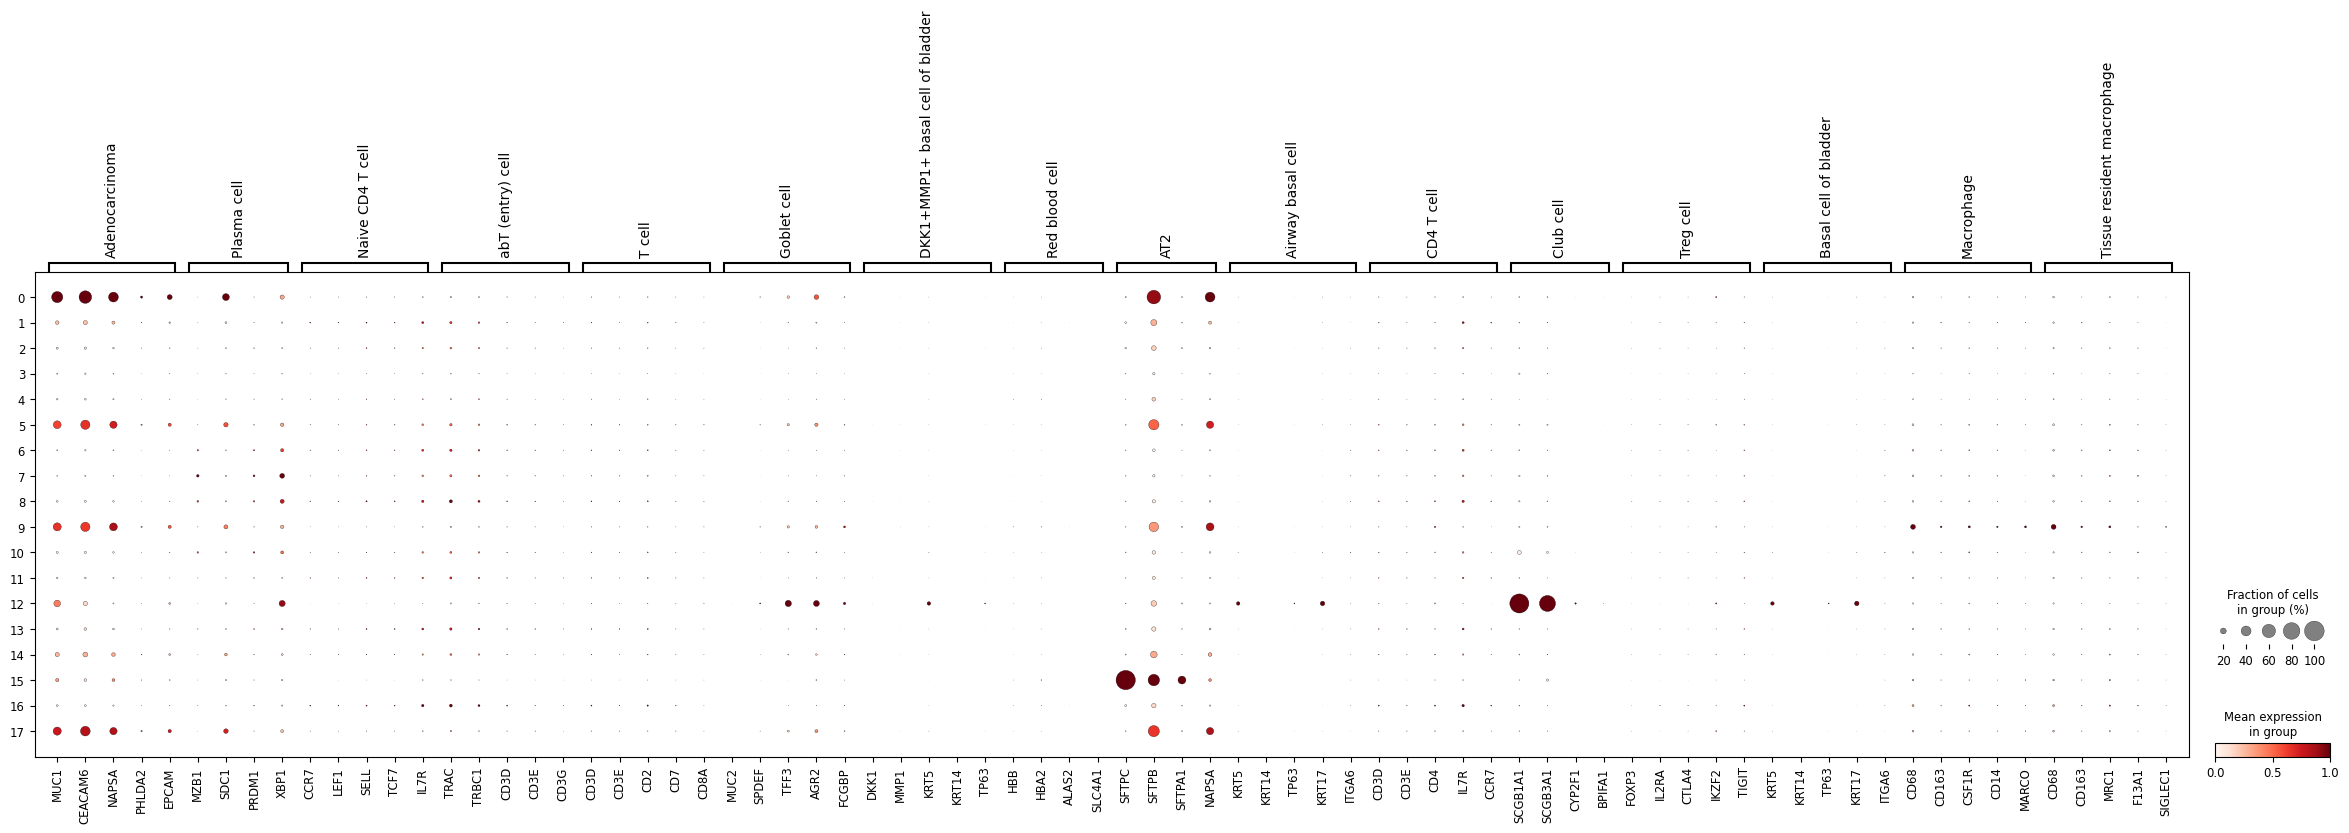

In [20]:
sc.pl.dotplot(adata, filtered_marker_genes, groupby="leiden_res_0.60", standard_scale="var")

In [21]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.60", method="wilcoxon")

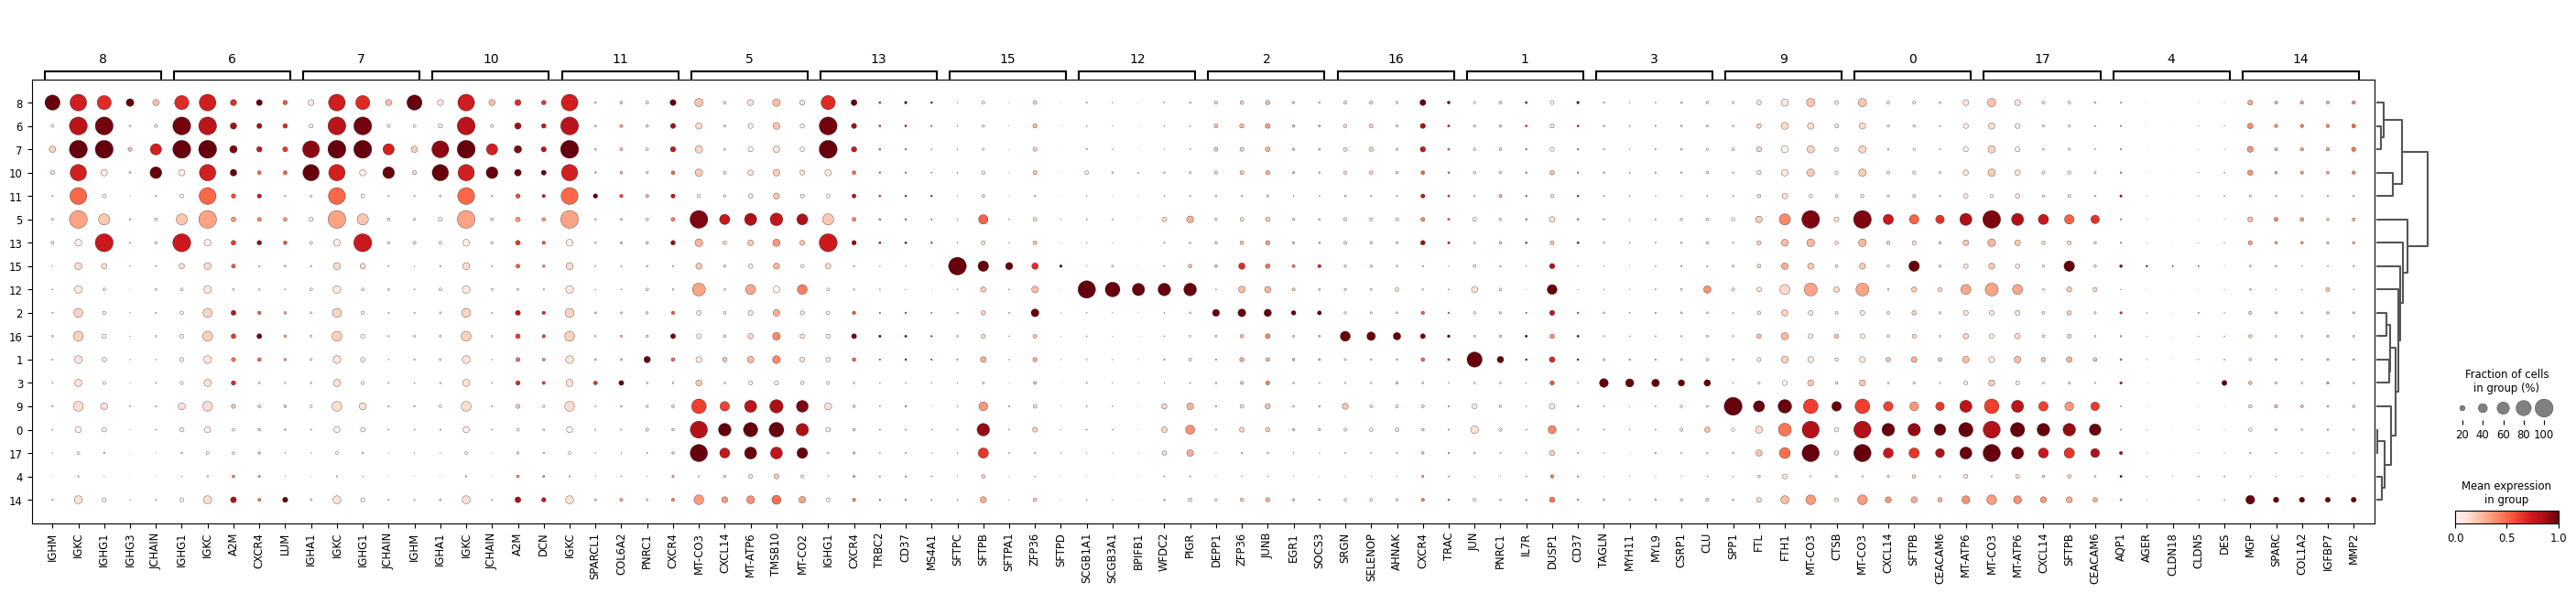

In [22]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.60", standard_scale="var", n_genes=5
)

In [25]:
sc.get.rank_genes_groups_df(adata, group="12").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,SCGB1A1,184.986832,8.185137,0.0,0.0
1,SCGB3A1,145.670135,6.982013,0.0,0.0
2,BPIFB1,115.914970,7.390154,0.0,0.0
3,WFDC2,108.121025,3.974975,0.0,0.0
4,PIGR,99.507652,2.879784,0.0,0.0


In [ ]:
sel_cluster = "12"  # Change this to the cluster of interest
name = "secretory_epithelial (club cells)"
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="12").head(5)["names"]

fig = sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.60"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    show=False,
    save=f"_umap_cluster_{sel_cluster}_genes_{name}.png"
)

# this is of yourse circular as the clusters were made based on the umap and the genes wer found based on the cluster DGE !!!

In [ ]:
# Save cell IDs and their corresponding leiden_res_0.70 cluster assignments
cell_ids = adata.obs.index
leiden_clusters = adata.obs["leiden_res_0.70"]

cell_id_cluster_df = pd.DataFrame({
    "cell_id": cell_ids,
    "": leiden_clusters
})

cell_id_cluster_df.to_csv("cell_id_leiden_res_0.70_x.csv", index=False)

In [ ]:
# Mapping of cluster labels to cell type labels based on previous annotation logic
cluster_to_celltype = {
    "16": "secretory/epithelial (club cells)",
    "4": "B-associated",
    "9": "B-associated",
    "3": "B-associated",
    "7": "B-associated",
    "6": "B-associated",
    "1": "B-associated",
    "5": "B-associated",
    "8": "B-associated",
    "15": "AT2",
    "0": "stressed AT2",
    "11": "stressed AT2",
    "13": "mesenchymal/stromal",
    "10": "recently activated/stressed",
    "18": "immune/stromal",
    "14": "smooth muscle",
    "12": "macrophage",
    "2": "undefined/mitochondrial"
}

pd.DataFrame(list(cluster_to_celltype.items()), columns=["cluster", "cell_type"]).to_csv("cluster_to_celltype_mapping_x.csv", index=False)